# VQE Demo

VQE demo with pennylane.

## VQE demo with molecular data

In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
import torch

from pennylane import numpy as np

In [6]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load in dataset for methane molecule.
dataset = qml.data.load("qchem", molname="CH2", bondlength=1.085, basis="STO-3G", attributes=["fci_energy", "hamiltonian"])

In [3]:
dataset[0].fci_energy

-38.47230370433298

In [4]:
# Construct hamiltonian.
H, qubits = dataset[0].hamiltonian, len(dataset[0].hamiltonian.wires)
print(f"Number of qubits: {qubits}")
print(f"Hamiltonian: {H}")

Number of qubits: 14
Hamiltonian: -24.01803924608539 * I(0) + 6.292442523016621 * Z(0) + 0.06846266470057542 * (Y(0) @ Z(1) @ Y(2)) + 0.06846266470057542 * (X(0) @ Z(1) @ X(2)) + 0.020282064285863835 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + 0.020282064285863835 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + 0.05622447382692242 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Y(10)) + 0.05622447382692242 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ X(10)) + 6.292442523016617 * Z(1) + 0.06846266470057538 * (Y(1) @ Z(2) @ Y(3)) + 0.06846266470057538 * (X(1) @ Z(2) @ X(3)) + 0.020282064285863818 * (Y(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Y(7)) + 0.020282064285863818 * (X(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ X(7)) + 0.05622447382692237 * (Y(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ Y(11)) + 0.05622447382692237 * (X(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(6) @ Z(7) @ Z(8) @ Z(9) @ Z(10) @ X(11)) 

In [12]:
from train import train_circuit

results, variational_circuit_params, loss = train_circuit(H, yaml_filepath="params.yaml")

Epoch 1: Loss = 4.47560872 Ha, Theta = [[-0.08660824 -0.1572991  -0.08788691 -0.11138757 -0.29241696  0.23279417]
 [-0.10760731 -0.10549996 -0.20176674  0.30966818 -0.25196755  0.14814933]
 [ 0.11729548  0.106314   -0.04231787 -0.15529121  0.15144126  0.05178282]
 [ 0.14653267 -0.1858409  -0.1623249   0.17932615 -0.16803762 -0.12420359]
 [-0.30814868 -0.16554937 -0.18185928  0.22411725 -0.13823065  0.0344984 ]
 [ 0.11117264 -0.14628935 -0.15179592 -0.30730844 -0.12964457  0.27033472]
 [-0.14699596 -0.12513877 -0.25837356 -0.16250831 -0.25725582 -0.0191399 ]
 [-0.13331676  0.23564632  0.09466869 -0.2981852  -0.1643532   0.0652343 ]
 [-0.1180016   0.20542827 -0.09116734  0.11590946 -0.1580846  -0.05140498]
 [ 0.19184199 -0.1055216   0.04314164  0.15410194  0.10675088 -0.00549179]
 [ 0.23984922 -0.14943382  0.10900034 -0.2204473  -0.2354087  -0.04811497]
 [ 0.22013174  0.14264628  0.01179668 -0.17663923 -0.12698084 -0.04579881]
 [ 0.3161425  -0.15805149  0.1943285  -0.13565812 -0.18635076

In [6]:
# Lets prepare the quantum circuit ansatz.
# We will prepare a quantum state with a 4 qubit Jordan Wigner representation
# with two states, one with both electrons in the ground state, and one with the
# electrons both in excited state.
# We can setup a hartree fock state which will be our starting point of the 
# vqe. We will use the hf state to form our quantum register.
electrons = 10
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 1 1 1 1 1 1 1 1 0 0 0 0]


In [26]:
def methane_ansatz(params, wires):
    if len(params) != wires:
        raise ValueError(f"Number of parameters does not match number of qubits.")

    for i in range(wires):
        # Assign the parameter to parameterised rotation X gate for each qubit.
        qml.RX(params[i], wires=i)
    for i in range(wires):
        # Assign the parameter to parameterised rotation X gate for each qubit.
        qml.RY(params[i], wires=i)
    for i in range(wires - 1):
        # Assign CNOT gate where first qubit is control qubit and second qubit is target qubit.
        qml.CNOT(wires=[i, i + 1])

# Circuit ansatz.
@qml.qnode(dev, interface="torch")
def circuit(params, hartree_fock_state, hamiltonian, num_wires):
    qml.BasisState(hartree_fock_state, wires=range(num_wires))
    methane_ansatz(params, num_wires)
    return qml.expval(hamiltonian)

# Cost function is simply the expectation value.
def cost_fn(params, hartree_fock_state, hamiltonian, qubits):
    return circuit(params, hartree_fock_state, hamiltonian, qubits)

Parameter containing:
tensor([ 0.1401, -0.2059, -0.0284, -0.0022,  0.0347,  0.0416,  0.1203, -0.0684,
         0.1195,  0.0715,  0.0044,  0.0504,  0.0111,  0.1923],
       requires_grad=True) 



C:\Users\Hoawen\AppData\Local\Temp\ipykernel_7348\1675933613.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


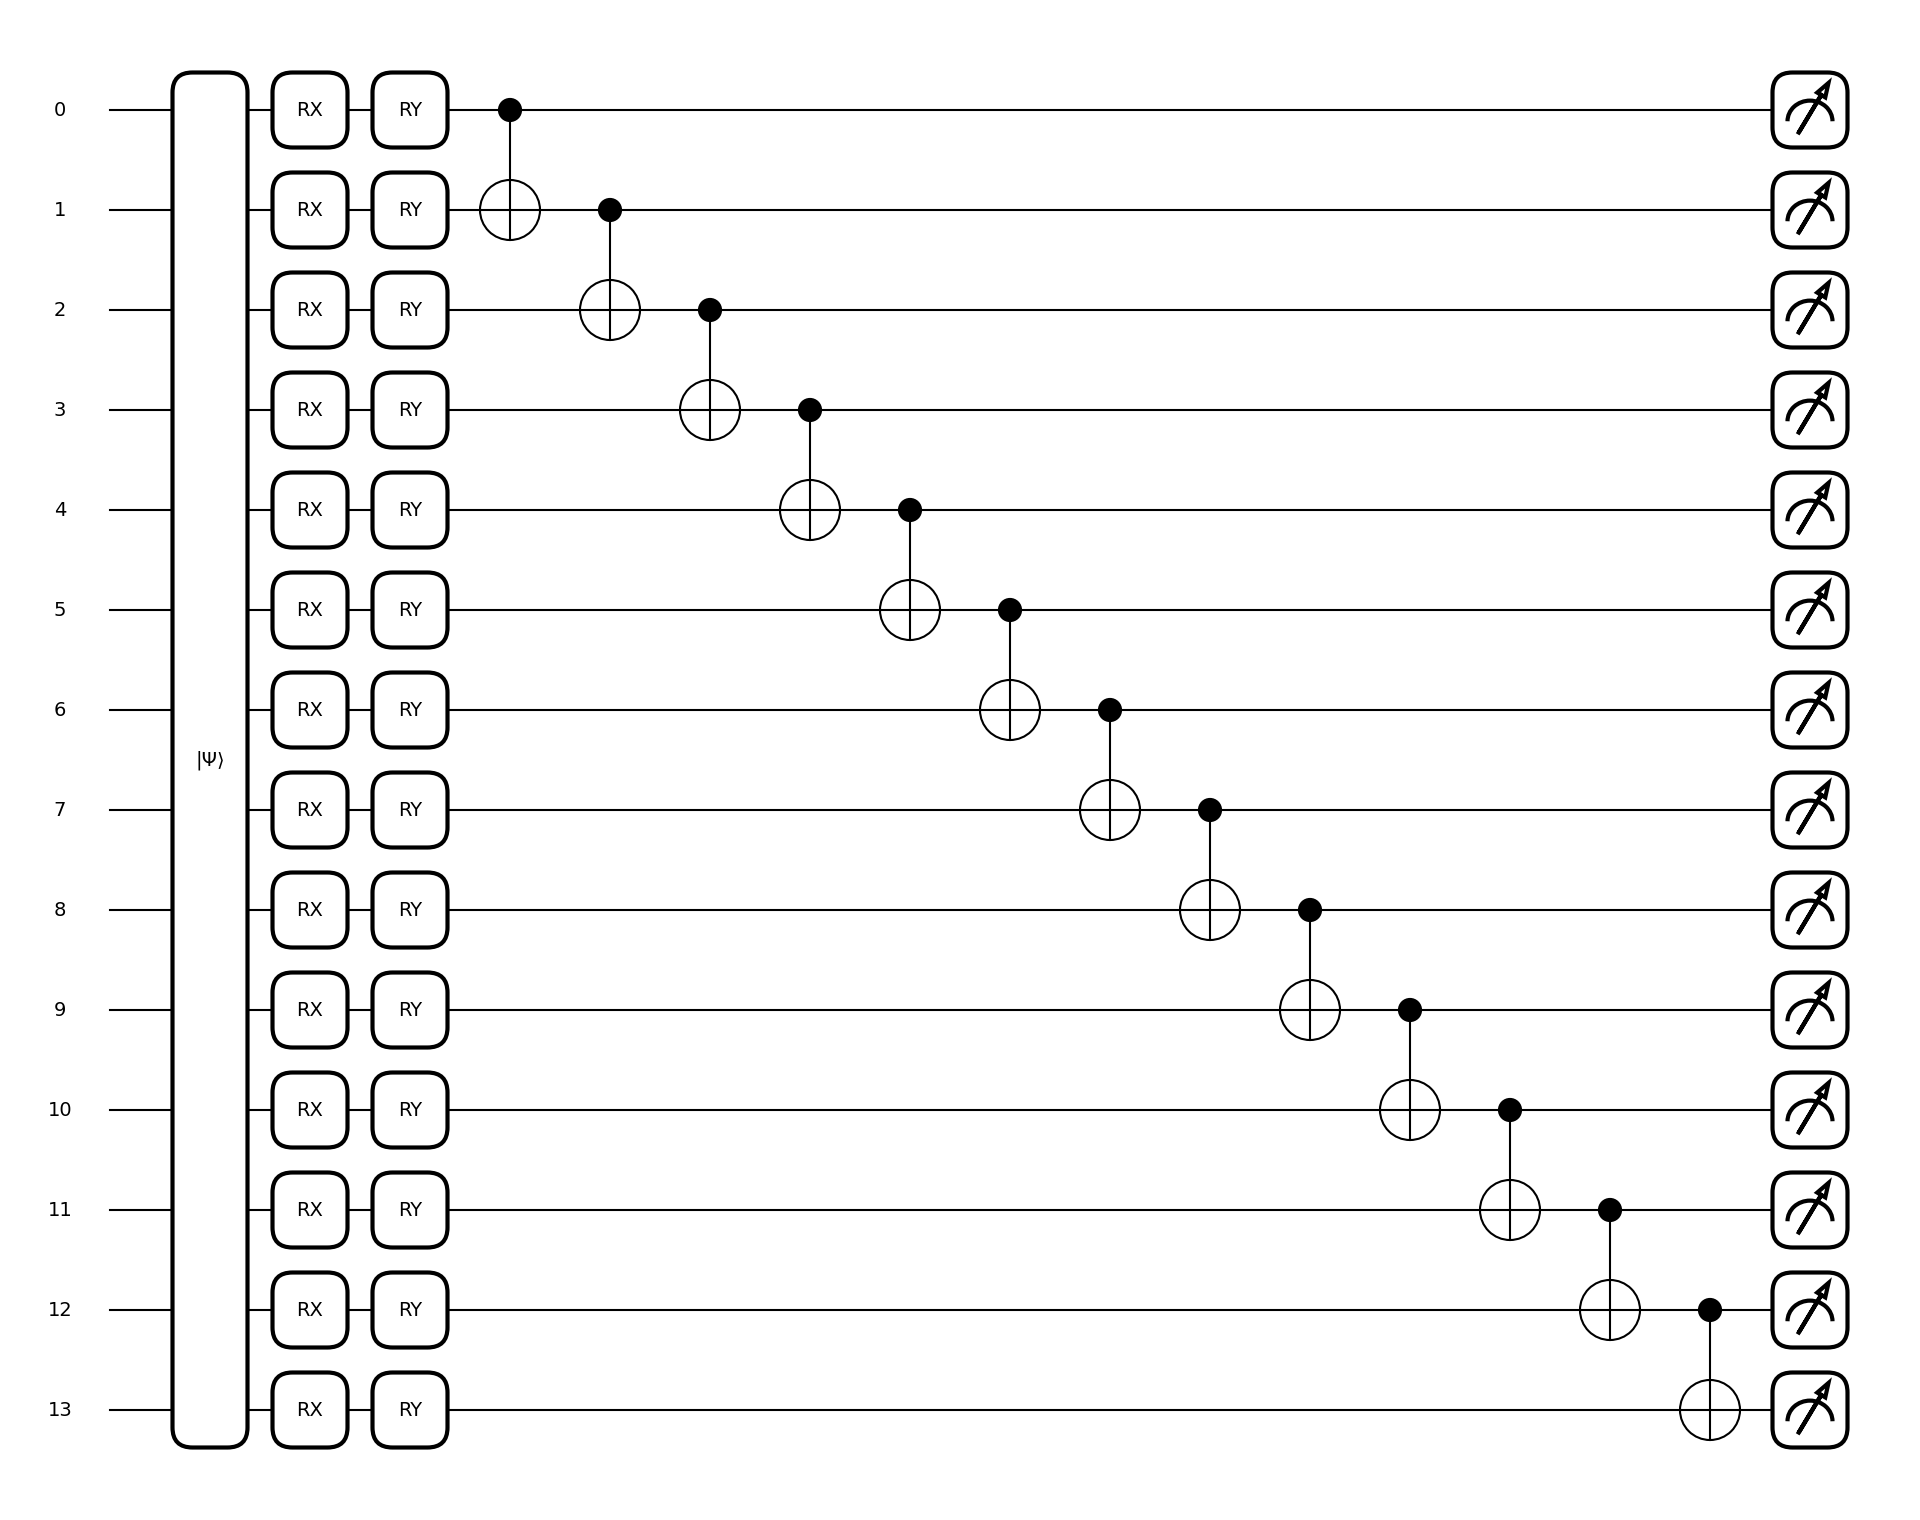

In [27]:
# Initialise container to store results
results = {"theta_param":[], 
           "energy_expectation_value":[]}


# Intialise theta parameter.
theta_value = torch.randn(qubits, requires_grad=True) * 0.1
theta_param = torch.nn.Parameter(theta_value)
print(theta_param, "\n")

# Draw circuit
fig, ax = qml.draw_mpl(circuit)(theta_param, hf, H, qubits)
plt.tight_layout()
plt.show()

# Initialise optimiser
opt = torch.optim.Adam([theta_param], lr=0.5)

In [28]:
# Training loop
epochs = 30
for i in range(epochs):
    # Ensure gradients are zero
    opt.zero_grad()

    # Run both the forward pass and calculate the cost function.
    # Remember cost function is the expectation value.
    loss = cost_fn(theta_param, hf, H, qubits)
    
    # Backpropagate.
    loss.backward()
    
    # Update parameters.
    opt.step()

    parameter_value = theta_param.clone().detach().numpy()

    results["theta_param"].append(parameter_value)
    results["energy_expectation_value"].append(loss.detach().numpy())

    print(f"Epoch {i + 1}: Loss = {loss.item():.8f} Ha, Theta = {theta_param.detach().numpy()}")

print(f"Final parameters: {theta_param}")
print(f"Final cost: {cost_fn(theta_param, hf, H, qubits).item():.4f}")

Epoch 1: Loss = -24.88184148 Ha, Theta = [ 0.640125   -0.7059268  -0.52844036 -0.5022109   0.5346563  -0.4583477
  0.6203493  -0.56836563  0.61948264  0.57145286  0.5043746   0.5503995
  0.5110689   0.69225645]
Epoch 2: Loss = -26.32410268 Ha, Theta = [ 0.27049753 -1.2003444  -0.21923897 -0.89383316  0.19438228 -0.08872876
  0.71432024 -0.1992414   1.0855043   0.2068479   0.88345194  0.9712584
  0.896947    1.1670208 ]
Epoch 3: Loss = -29.78849962 Ha, Theta = [-0.15799344 -1.6982892   0.1400441  -1.3338819  -0.15470383  0.2205773
  0.60869527  0.15934533  1.4218711  -0.16554993  1.2557915   1.4097924
  1.3120505   1.6318061 ]
Epoch 4: Loss = -30.75811426 Ha, Theta = [-0.34213734 -2.0222178   0.28369486 -1.5637264  -0.42123458  0.3376691
  0.40133333  0.36701226  1.6709449  -0.39506572  1.5893593   1.8021213
  1.6948886   1.9974331 ]
Epoch 5: Loss = -29.38263643 Ha, Theta = [-0.30089122 -2.093187    0.16664903 -1.7942753  -0.5411822   0.27674094
  0.14297372  0.41750726  1.9296746  -0.4

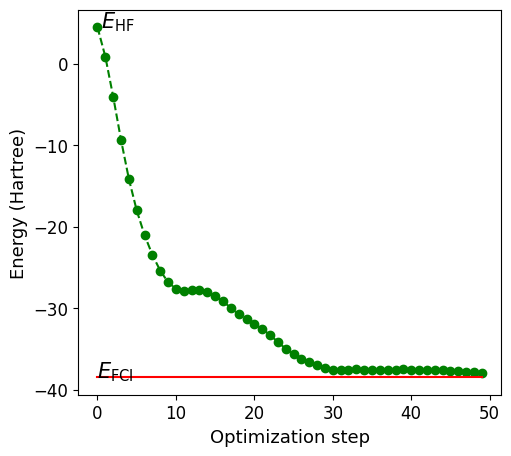

In [13]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

num_data_points = len(results["theta_param"])

# Full configuration interaction (FCI) energy computed classically
E_fci = dataset[0].fci_energy

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(0, num_data_points), results["energy_expectation_value"], "go", ls="dashed")
ax1.plot(range(0, num_data_points), np.full(num_data_points, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, results["energy_expectation_value"][0], r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, E_fci, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()